# Traffic Signs Classification
Here i'm gonna be trying to classify traffic signs from crops that are going to be coming for a YOLO detector, since YOLO doesn't have much accuracy, but it detects traffic signs, I'm going to take the bounding box from YOLO, crop the image, and pass it through this classifier.

Let's see if it actually works **;)**

If you want to skip the set-up go to the [Model-1](#Model-1) section.

In [1]:
import os
import cv2
import csv
import glob
import pickle
import random
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 6)

In [2]:
# Data path
data_path = 'data/custom/'

# Pickle files
train_pickle_file = 'train.p' 
valid_pickle_file = 'valid.p'
test_pickle_file = 'test.p'

# Classes file
classes_file = 'classes.csv'

In [3]:
# Load classes
with open(os.path.join(data_path, classes_file), mode='r') as csv_file:
    reader = csv.reader(csv_file)
    classes = {rows[0]:rows[1] for rows in reader}

In [4]:
# Load train data
train_file = open(os.path.join(data_path, train_pickle_file), 'rb')
train_data = pickle.load(train_file)

# Load valid data
valid_file = open(os.path.join(data_path, valid_pickle_file), 'rb')
valid_data = pickle.load(valid_file)

# Load test data
test_file = open(os.path.join(data_path, test_pickle_file), 'rb')
test_data = pickle.load(test_file)

In [5]:
# Data shapes
print('Train data shape:', train_data['features'].shape)
print('Valid data shape:', valid_data['features'].shape)
print('Test data shape:', test_data['features'].shape)

Train data shape: (8505, 64, 64, 3)
Valid data shape: (2837, 64, 64, 3)
Test data shape: (4620, 64, 64, 3)


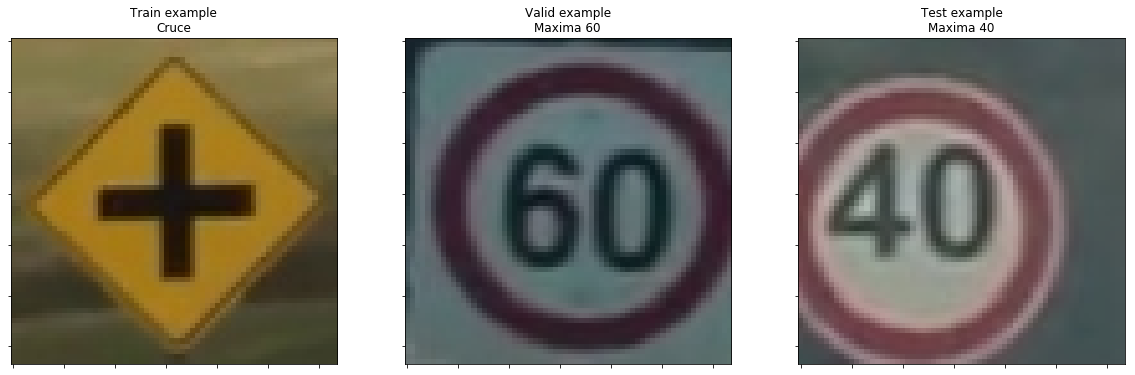

In [6]:
# Verify data
fig = plt.figure()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

index = random.randrange(0, len(train_data['features']))
ax1.imshow(train_data['features'][index])
ax1.set_title('Train example\n' + classes[str(train_data['labels'][index])])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

index = random.randrange(0, len(valid_data['features']))
ax2.imshow(valid_data['features'][index])
ax2.set_title('Valid example\n' + classes[str(valid_data['labels'][index])])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

index = random.randrange(0, len(test_data['features']))
ax3.imshow(test_data['features'][index])
ax3.set_title('Test example\n' + classes[str(test_data['labels'][index])])
ax3.set_yticklabels([])
ax3.set_xticklabels([])

plt.show()

In [7]:
import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D

from keras.optimizers import SGD

Using TensorFlow backend.


In [8]:
# Define image parameters
IMG_SIZE = 64
IMG_DEPTH = 3
NUM_CLASSES = 9

# Define checkpoints path
CHECKPOINT_PATH = 'checkpoints/'

# Model 1
For the first try I'm using the network architecture used in [this](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) Keras example for the MNIST handwritten digits dataset.

In [9]:
# Model name
MODEL_NAME = 'model_1_custom'

In [10]:
# Define model parameters
BATCH_SIZE = 256
EPOCHS = 32

In [11]:
# Define model
def model_1(weights_path=None):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_DEPTH)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [12]:
# Create model
model = model_1()

In [13]:
# Callbacks
filepath = MODEL_NAME + '-weights-{epoch:02d}-{val_acc:.2f}.hdf5'
folder = os.path.join(CHECKPOINT_PATH, MODEL_NAME)
filepath = os.path.join(folder, filepath)

callbacks = [
                keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_acc', 
                                                verbose=0, 
                                                save_best_only=False, 
                                                save_weights_only=False, 
                                                mode='auto', 
                                                period=1),
                keras.callbacks.TensorBoard(log_dir='./logs', 
                                            histogram_freq=0, 
                                            write_graph=True, 
                                            write_images=False, 
                                            embeddings_freq=0, 
                                            embeddings_layer_names=None, 
                                            embeddings_metadata=None)
            ]

In [14]:
# Compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
# Organize training and testing data
x_train = train_data['features']
y_train = train_data['labels']

x_valid = valid_data['features']
y_valid = valid_data['labels']

x_test = test_data['features']
y_test = test_data['labels']

In [16]:
# Make RGB values between 0 and 1
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_valid /= 255
x_test /= 255

In [17]:
# Convert labels to one hot encoding
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

In [18]:
# Fit model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

Train on 8505 samples, validate on 2837 samples
Epoch 1/32
 768/8505 [=>............................] - ETA: 70s - loss: 2.1626 - acc: 0.1198

KeyboardInterrupt: 

In [31]:
"""
Optional, load model weights
"""

model = model_1('checkpoints/model_1_custom/model_1_custom-weights-31-0.99.hdf5')

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [32]:
# Evaluate model on valid data
score = model.evaluate(x_valid, y_valid, verbose=0)

print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

Valid loss: 0.0464424233432
Valid accuracy: 0.98836799436


In [33]:
# Evaluate model on test data
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.707308036872
Test accuracy: 0.814264919907


In [ ]:
# Evaluate model
file_filter = '*.hdf5'
weights_files = glob.glob(os.path.join(folder, file_filter))

data = {}

for weight_file in weights_files:
    # Load weights
    model = model_1(weight_file)
    
    # Compile model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # Evaluate model
    score = model.evaluate(x_test, y_test, verbose=0)
    
    data[weight_file] = {'test_loss': score[0], 'test_acc': score[1]}

In [ ]:
max_acc = 0
max_acc_weights = None

for key in data.keys():
    if data[key]['test_acc'] > max_acc:
        max_acc = data[key]['test_acc']
        max_acc_weights = key

In [ ]:
print('Max accuracy:', max_acc, 'with', max_acc_weights)

In [ ]:
# Test on external image

file_filter = '*.png'
test_folder = 'data/test/'

test_files = glob.glob(os.path.join(test_folder, file_filter))

fig = plt.figure()
position = '24{}'
index = 1

for image_path in test_files:
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img[...,::-1]

    # Predict label for external test image
    img_test = np.expand_dims(img, axis=0)
    predictions = model.predict(img_test)

    class_id = np.argmax(predictions)
    class_label = classes[str(class_id)]

    # Plot
    ax = fig.add_subplot(int(position.format(index)))
    ax.imshow(img)
    ax.set_title(class_label)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    
    index += 1

plt.show()